In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

import pandas as pd
import numpy as np

df_train = pd.read_csv('train_kaggle.csv')
df_test = pd.read_csv('sample_solution.csv')
Y = df_train['Label'].values
dataframes = np.load('allData.npy', allow_pickle = True)

In [3]:
def load_test_dataframe(id):
    test_data = np.load("test/test/{}.npy".format(id))
    return pd.DataFrame(data=test_data)

testdatas = []
for id in df_test['Id']:
    dfi = load_test_dataframe(id)
    testdatas.append(dfi.values)

In [4]:
dfLens = []
for df in dataframes:
    dfLens.append(df.shape[0])
np.min(dfLens)

38

In [5]:
def pad_data(dfs):
    padsize = np.min(dfLens)
    data = []
    for df in dfs:
        diff = padsize-df.shape[0]
        if diff >0:
            df = np.pad(df, [(0, diff), (0,0)], 'constant')
        else:
            df = df[:padsize]
        data.append(df)
        
    data = np.stack(data)
    return data

XTrain = pad_data(dataframes)
XTest = pad_data(np.array(testdatas))

In [10]:
import sklearn as sk
from sklearn.metrics import pairwise_distances

# Convert time series to image based on https://www.kaggle.com/tigurius/recuplots-and-cnns-for-time-series-classification
#modified from https://stackoverflow.com/questions/33650371/recurrence-plot-in-python
def recurrence_plot(s, eps=None, steps=None):
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    #Z = squareform(d)
    return d

In [11]:
XTrain = np.array(list(map(recurrence_plot, XTrain)))
XTrain.shape

(18662, 38, 38)

In [12]:
XTest = np.array(list(map(recurrence_plot, XTest)))
XTest.shape

(6051, 38, 38)

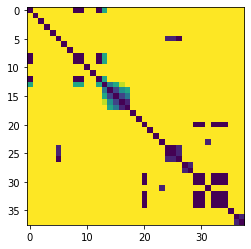

In [14]:
import matplotlib.pyplot as plt

plt.imshow(XTrain[0])

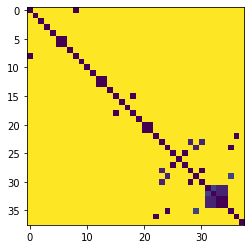

In [15]:
plt.imshow(XTrain[1])

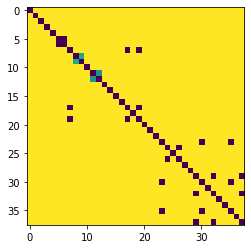

In [16]:
plt.imshow(XTrain[2])

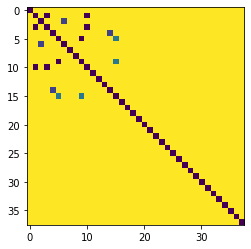

In [17]:
plt.imshow(XTrain[3])

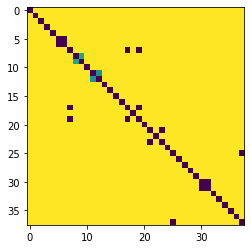

In [18]:
plt.imshow(XTrain[4])

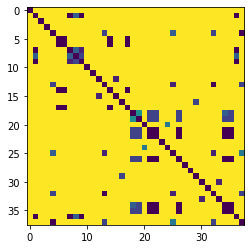

In [19]:
plt.imshow(XTrain[5])

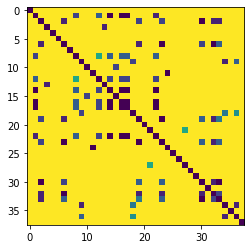

In [23]:
plt.imshow(XTrain[217])

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(XTrain, Y, test_size=0.2, random_state=42)

## CNNs for Recurrence plots
In https://arxiv.org/pdf/1710.00886.pdf the usage of a convolutional net for classification of recurrence plots is proposed.

In [44]:
import tensorflow as tf
from tensorflow import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

inputs = keras.Input(shape=(XTrain.shape[1], XTrain.shape[2])) 
x = tf.reshape(inputs, (-1, 1, XTrain.shape[1], XTrain.shape[2]))
x = keras.layers.Convolution2D(36, (3, 3), activation='relu', data_format='channels_first')(x)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Convolution2D(36, (3, 3),activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=x)

model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Take a look at the model summary
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 38, 38)]          0         
_________________________________________________________________
tf_op_layer_Reshape_10 (Tens [(None, 1, 38, 38)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 36, 36, 36)        360       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 18, 18, 36)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 18, 18, 36)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 36)        11700     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 36)          0  

In [39]:
EPOCHS = 100
baseline_history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val))

Train on 14929 samples, validate on 3733 samples
Epoch 1/100
14929/14929 [==============================] - 80s 5ms/sample - loss: 0.4765 - accuracy: 0.7688 - auc: 0.8439 - val_loss: 0.3339 - val_accuracy: 0.8422 - val_auc: 0.9344
Epoch 2/100
14929/14929 [==============================] - 79s 5ms/sample - loss: 0.3408 - accuracy: 0.8454 - auc: 0.9251 - val_loss: 0.2815 - val_accuracy: 0.8720 - val_auc: 0.9483
Epoch 3/100
14929/14929 [==============================] - 77s 5ms/sample - loss: 0.3059 - accuracy: 0.8622 - auc: 0.9406 - val_loss: 0.2711 - val_accuracy: 0.8805 - val_auc: 0.9548
Epoch 4/100
14929/14929 [==============================] - 78s 5ms/sample - loss: 0.2847 - accuracy: 0.8732 - auc: 0.9492 - val_loss: 0.2542 - val_accuracy: 0.8856 - val_auc: 0.9605
Epoch 5/100
14929/14929 [==============================] - 77s 5ms/sample - loss: 0.2652 - accuracy: 0.8815 - auc: 0.9558 - val_loss: 0.2468 - val_accuracy: 0.8923 - val_auc: 0.9607
Epoch 6/100
14929/14929 [================

In [46]:
YTest = model.predict(XTest)
df_test['Predicted'] = YTest[:, 0]
df_test

,Id,Predicted
0,0,9.999983e-01
1,1,8.599497e-01
2,2,8.046627e-07
3,3,4.914441e-01
4,4,5.527620e-01
5,5,1.309122e-01
6,6,6.258488e-07
7,7,6.560699e-01
8,8,9.999983e-01
9,9,9.997185e-01


In [47]:
df_test.to_csv('test.csv', index=False)